In [1]:
#Headers for the analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.svm import SVR




from numpy import array
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Input

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

np.random.seed(1234)
tf.random.set_seed(1234)

import timeit

2024-08-28 12:19:57.039107: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 12:19:57.059506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 12:19:57.059524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 12:19:57.059538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 12:19:57.063698: I tensorflow/core/platform/cpu_feature_g

In [2]:
#Filler functions
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))#, squared=False)
# Fixed values for the device, not going to change based on our requirement

freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]
freq_dict['bFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000]
# cost_list =['cCost','mCost','gCost']
cFreq = 'bFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'

cost2FMap = {}
cost2FMap['cCost'] = 'bFreq'
cost2FMap['mCost'] = 'mFreq'
cost2FMap['gCost'] = 'gFreq'

## Function to extract the files and send a dataframe

def extractDatafromFile(fileName='./UtilTestFinal',padding=0): ## Generally make the padding 0
    new_data = pd.read_csv(fileName)
    #### This part needs to be 
    if padding == 1:  # if there is not 
        new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = 0
        new_data['gFreq'] = 600000000
    elif padding == 2:  # if there is not 
        # new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        # new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = new_data['gCost']*new_data['gFreq']/600000000
        # new_data['gFreq'] = 600000000
    elif padding == 3:  # if there is not 
        new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        new_data['mCost'] = new_data['mCost']*new_data['mFreq']/825000000
        new_data['gCost'] = new_data['gCost']*new_data['gFreq']/600000000
        new_data[['cCost','mCost','gCost']] = new_data[['cCost','mCost','gCost']].clip(0,100)
        # new_data['gFreq'] = 600000000

    return new_data

#extractDatafromFile()
# Getting the exog list for analysis

def getExog(endog='cCost'):
    cost_list =['cCost','mCost','gCost']
    if endog not in cost_list:
        print("Incorrect Value")
        return None,None
    else:
        my_list = []
        for res in cost_list:
            if res != endog:
                my_list.append(res)
        return my_list[0],my_list[1]

# getExog('gCost')

## Function to shift the data, enabling testing and trainig

def createRequiredDataSet(input_df,endog,shiftAR,shiftARX,b_exog=True):
    modified_df = pd.DataFrame()
    ## Get the exog values
    exog,exog1 = getExog(endog)
    if b_exog == True:
        modified_df = input_df[[endog,exog,exog1]]
    else:
        modified_df = input_df[[endog]]
    # Shifting the endog data
    for i in range(1,shiftAR+1):
        modified_df['%s_%d'%(endog,i)] = modified_df[endog].shift(i)
    if b_exog==True:
    # Shifting the exog and exog1 data
        modified_df[exog] = modified_df[exog].shift(1)
        modified_df[exog1] = modified_df[exog1].shift(1)
    
        for i in range(1,shiftARX+1):
            modified_df['%s_%d'%(exog,i)] = modified_df[exog].shift(i+1)
            modified_df['%s_%d'%(exog1,i)] = modified_df[exog1].shift(i+1)

    # Adding the frequency stuff
    modified_df[cFreq] = input_df[cFreq] 
    modified_df[mFreq] = input_df[mFreq] 
    modified_df[gFreq] = input_df[gFreq] 
    modified_df = modified_df.dropna()
    return modified_df


## Test_train divide

def test_train_split(input_df,trainIDX,testIDX,perc=0.8):
    totalLen = len(input_df)
    if trainIDX == -1 or testIDX == -1:
        trainIDX = int(perc*totalLen)
        testIDX = int(perc*totalLen)
    train_df = input_df.iloc[:trainIDX,:]
    test_df = input_df.iloc[testIDX:,:]
    return train_df,test_df


## get the matrices for training, we are assuming that 0 is the y value and the rest are x, we can choose to skip few columns

def getYXData(input_df,ignoreCols=0):
    totalLen = len(input_df.columns)
    y_data = input_df.iloc[:,0].to_numpy()
    x_data = input_df.iloc[:,1:totalLen-ignoreCols].to_numpy()
    return y_data,x_data


def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u


def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result



def simple_test_single(model, xData):
    newX = [1.0]
    newX.extend(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    return y_pred

def getSingleCluster(data, cntr):
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([data]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut


def prediction(model,x,cluster):
    ## get cluster
    N_CLUST = len(model)
    prob_d = getSingleCluster(x,cluster).T[0]
    y = []
    for i in range(N_CLUST):
        ys = simple_test_single(model[i],x)
        y.append(ys*prob_d[i])
    my_pred = min(sum(y)[0],100.0)
    return my_pred


# Prediction of just simple Mean
def prediction_mean(x,hist):
    ## get cluster
    # N_CLUST = len(model)
    # prob_d = getSingleCluster(x,cluster).T[0]
    # y = []
    # for i in range(N_CLUST):
    #     ys = simple_test_single(model[i],x)
    #     y.append(ys*prob_d[i])
    my_pred = np.mean(x[:hist])
    return my_pred

In [3]:
def getPredF(est_util, act_util, freq_list):
    eff_u = -1
    max_f = max(freq_list)
    est_freq = max_f
    for f in freq_list:
        eff_u = est_util * max_f/f
        if eff_u <=100 or f == max_f:
            eff_y = act_util * max_f/f
            return f,eff_u,eff_y
    return max_f,-1,-1
# def getPredF(est_util, act_util, freq_list): ## Take the higher frequency if possible
#     eff_u = -1
#     max_f = max(freq_list)
#     est_freq = max_f
#     for fidx in range(len(freq_list)):
#         f = freq_list[fidx]
#         eff_u = est_util * max_f/f
#         if eff_u <=100 or f == max_f:
#             eff_y = act_util * max_f/freq_list[min(fidx+1,len(freq_list)-1)]
#             return f,eff_u,eff_y
#     return max_f,-1,-1
def energy_perf_analysis(y_act,y_est,act_freq,endog, details=False):
    eff_util = []
    est_freq = []
    possible_freq_config = freq_dict[cost2FMap[endog]] ## list of all possible frequency in increasing order
    LEN = len(y_act)
    energy_save = 0.
    for idx in range(LEN):
        pred_f, eff_u, eff_y = getPredF(y_est[idx],y_act[idx],possible_freq_config)
        eff_util.append(eff_y)
        est_freq.append(pred_f)
        # print(pred_f, act_freq[idx])
        energy_save += math.ceil(eff_y/100.) * (pred_f/act_freq[idx])**2
        
        
    stall = (sum( i > 100 for i in eff_util ) * 100) / LEN
    energy_ratio = 1.0 - (energy_save/LEN)
    if details:
        return stall, energy_ratio, est_freq, eff_util
    return stall, energy_ratio

    
## Plot the error
def plotErrDist(y_est,y_actual,bins=10):
    err = np.array(y_est) - np.array(y_actual)
    print("min:",min(err),", max : ",max(err))
    ybins, xbins, bar = plt.hist(err, color='lightblue', ec='black', bins=bins)
    print("Mode error: ", xbins[np.argmax(ybins)])
    plt.show()
    return

In [18]:
def ModelPipeline(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    start = timeit.default_timer()
    cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    model = []
    for i in range(N_CLUST):
        out_model = simple_train(y_train,x_train,weight = prob[i,:])
        model.append(out_model)
    stop = timeit.default_timer()
    print('Train Time: ', stop - start) 
    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction(model,x_test[id],cluster_center)
        ys_est.append(max(0,min(predVal,100)))
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    

In [24]:
## 
file='./TraceData/TraceSSSP'
pad = 3
test_endog = 'gCost'
TrIDX = 1000
TIDX = 1000
TLEN = 200

1388


<Axes: >

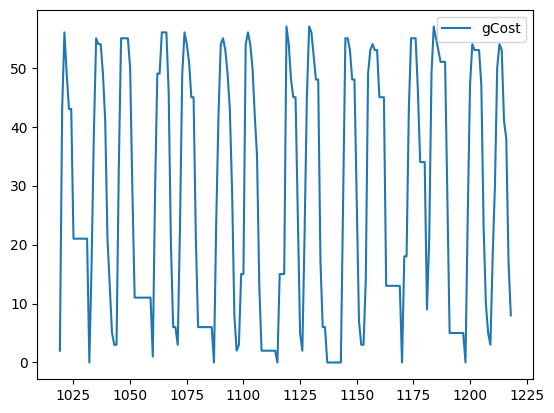

In [25]:
# dataset = pd.read_csv('./TraceData/TraceBig2')
dataset = extractDatafromFile(file,3)
print(len(dataset))
# dataset['mCost'] = min(dataset['mCost'] , 100.0)
# dataset['mCost'] = dataset['mCost'].clip(0,100)
dataset[[test_endog]].iloc[TIDX+19:TIDX+TLEN+19].plot()
# new_data = dataset[['cCost','mCost','gCost','gFreq']]
# new_data['gCost'] = new_data['gCost']*new_data['gFreq']/600000000
# # new_data[['cCost','gCost','mCost']].plot()
# new_data[['mCost']].iloc[50:350].plot()

In [26]:
my_data = []
for val in range(2,20):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=15,shiftAR=val,shiftARX=val-5,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    # plotErrDist(y_est,y_act,60)
    data = data = (val,rms,stall,energy,y_est,y_act,est_freq, act_freq,eff_util)
    my_data.append(data)
    

Train Time:  0.13892495003528893
#AR  2  RMSE : 9.422544626770192
Train Time:  0.043088575126603246
#AR  3  RMSE : 9.189702109942635
Train Time:  0.10268936911597848
#AR  4  RMSE : 8.835035289143423
Train Time:  0.025975679978728294
#AR  5  RMSE : 8.721278936101772
Train Time:  0.0556606431491673
#AR  6  RMSE : 8.836545318581095
Train Time:  0.07023655390366912
#AR  7  RMSE : 8.800272651910827
Train Time:  0.0529408638831228
#AR  8  RMSE : 8.725312734477196
Train Time:  0.4323281568940729
#AR  9  RMSE : 8.50677589354175
Train Time:  0.2950389210600406
#AR  10  RMSE : 8.37131491009858
Train Time:  0.1174935030285269
#AR  11  RMSE : 8.5059902094604
Train Time:  0.18172403005883098
#AR  12  RMSE : 8.43251542725649
Train Time:  0.28400402306579053
#AR  13  RMSE : 8.563922218647088
Train Time:  0.21047598007135093
#AR  14  RMSE : 8.505993354013027
Train Time:  0.17099324404262006
#AR  15  RMSE : 8.487387816050864
Train Time:  0.18415844393894076
#AR  16  RMSE : 8.448665951084461
Train Time:

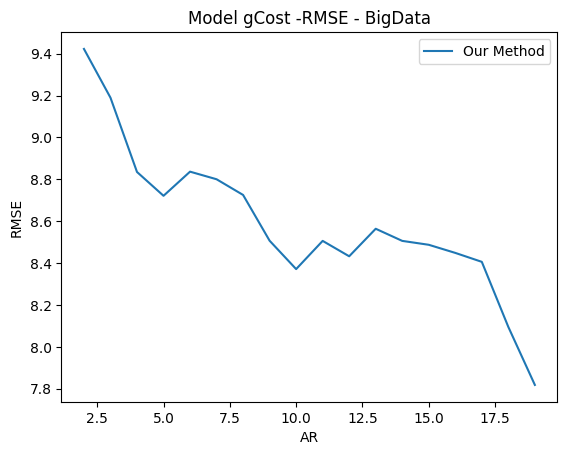

In [27]:
##Combined Plot
x = list(map(lambda x: x[0], my_data))
y = list(map(lambda x: x[1], my_data))
plt.plot(x, y, label='Our Method') 
# plt.plot(x, y_svr, label='SVR') 
# plt.plot(x, y_mean, label='Mean') 
# plt.plot(x, y_lstm, label='LSTM') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Model {} -RMSE - BigData".format(test_endog)) 
plt.legend() 
plt.show() 

[]

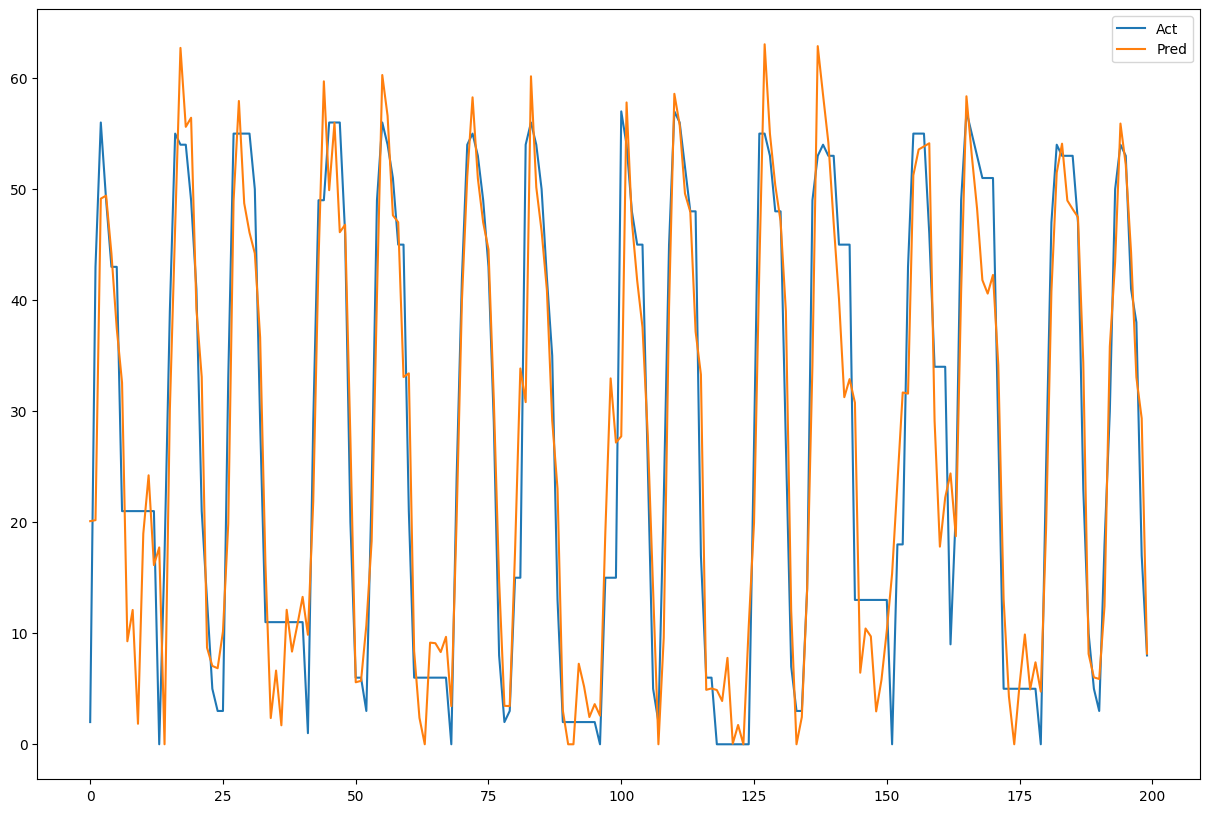

In [28]:
#Plotting pred vs actual

y_pred = my_data[-1][4]
y_obs = my_data[-1][5]
plot_df = pd.DataFrame()
plot_df['Pred'] = y_pred
plot_df['Act'] = y_obs
ax = plot_df[['Act','Pred']].plot(figsize=(15,10))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()